In [1]:
%cd /home/hess/projects/discriminator-guidance/
%load_ext autoreload
%autoreload 1

/home/hess/projects/discriminator-guidance


In [2]:
import numpy as np

import time
import torch
import torch.utils.data
from torch.utils.data import DataLoader
from IPython.display import Image, display
import matplotlib.pyplot as plt
import lightning.pytorch as pl
import torch.utils.data as data_utils
import polars as pol
from tqdm import tqdm
import xarray as xr
import xskillscore as xs
import pandas as pd
import pickle 
from matplotlib.animation import FuncAnimation
import wandb
import sys

import src.xarray_utils as xu
from src.edm.data import DataModule
from src.edm.diffusion_model import DiffusionModel
from src.edm.inference import DiffusionInference
from src.edm.diffusion_stochastic_sampler import KarrasStochasticSampler
from src.config import read_yaml

from diffusion_training import main

# create training data

In [3]:
fname = "/p/tmp/hess/scratch/turbulence-simulation/experiment_small/2d_turbulence_step_*"
ds = xr.open_mfdataset(fname)
ds

<xarray.Dataset> Size: 16GB
Dimensions:    (time: 501000, lat: 64, lon: 64)
Coordinates:
  * time       (time) int64 4MB 0 1 2 3 4 ... 500995 500996 500997 500998 500999
  * lat        (lat) int64 512B 1 2 3 4 5 6 7 8 9 ... 56 57 58 59 60 61 62 63 64
  * lon        (lon) int64 512B 1 2 3 4 5 6 7 8 9 ... 56 57 58 59 60 61 62 63 64
Data variables:
    vorticity  (time, lat, lon) float64 16GB dask.array<chunksize=(1000, 64, 64), meta=np.ndarray>

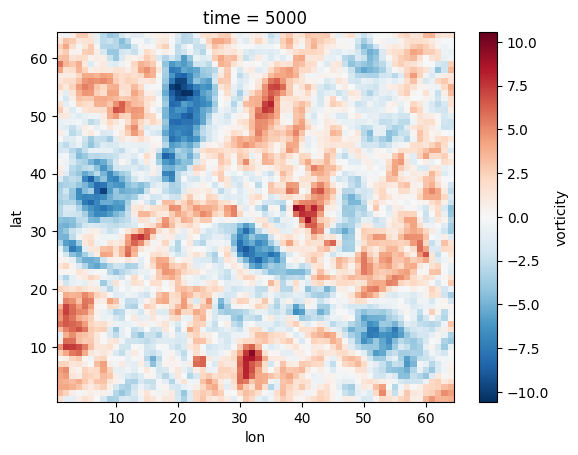

In [14]:
ds.vorticity[5000].plot()

In [15]:
ds_sub = ds.isel(time=slice(5000,95_000)).rename({"lat": "latitude", "lon": "longitude"})
start_date = "2000-01-01"
num_days = len(ds_sub.time)  
new_time = pd.date_range(start=start_date, periods=num_days, freq="D")
ds_sub = ds_sub.assign_coords(time=new_time)


In [17]:
xu.write_dataset(ds=ds_sub, file_name="/p/tmp/hess/scratch/constrained-generation/datasets/vorticity_small_64.nc")

writing to /p/tmp/hess/scratch/constrained-generation/datasets/vorticity_small_64.nc
[########################################] | 100% Completed | 1.61 sms


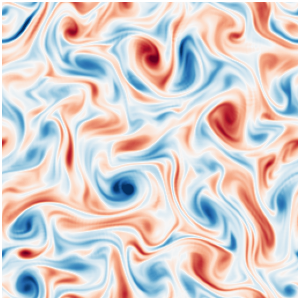

In [55]:
fig, ax = plt.subplots(1,1,figsize=(6, 6), constrained_layout=True)
def update(i):
    cmap='RdBu'
    
    ax.imshow(ds_sub.vorticity[i],vmin=-15, vmax=15, origin='lower', cmap=cmap)
    ax.set_axis_off()
update(1)

output_filename = '/p/tmp/hess/scratch/constrained-generation/results/dg_2dturb_2.gif'
anim = FuncAnimation(fig, update, frames=np.arange(0, 20), interval=250, repeat=False)
anim.save(output_filename, dpi=50)
plt.close()

display(Image(filename=output_filename))